# Lottery number 

## Imports

In [229]:
import argparse, configparser, copy, csv, datetime
import matplotlib.pyplot as plt
plt.rc('font', family='Hiragino Kaku Gothic Pro')
plt.rcParams['figure.figsize'] = (16, 6)

import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 8)

from sklearn.model_selection import train_test_split

## Arguments

In [230]:
# =================================================
# Parse arguments
parser = argparse.ArgumentParser()
# Config
parser.add_argument("-c", "--config_file", type=str, help='Config file for the lottery type (default: nil)')
# Debug and log
parser.add_argument('-d', '--debug', action='store_true', help='Debug mode (default: false)')
parser.add_argument('-l', '--log_file_name', type=str, default=datetime.date.today().strftime('%Y%m')+'.log',
        help='Log file name (default: %Y%m.log)')
# Lottery game definition
parser.add_argument('-L', '--lottery_max_number', type=int, default=31,
        help='Lottery game max numbers. (default: 31)')
parser.add_argument('-p', '--pick', type=int, default=5,
        help='Number of pick in one game (default: 5)')
# Detail of input data
parser.add_argument('-f', '--file_path', type=str, help='CSV file path (default: nil)')
parser.add_argument('-r', '--remove_lines', type=int, default=0,
        help='Remove unnecessary header lines in csv file (default: 0)')
parser.add_argument('-a', '--appearance_first_number_order', type=int, default=0,
        help='Order of First number appears on the row in csv file (default: 0)')
parser.add_argument('--perge_data_percentage', type=float, default=0.0,
        help='Perge older data to improve accuracy. 0.0 < Input in percentage < 1.0 (default: 0.0)')
# For formating data
parser.add_argument('--test_size', type=float, default=0.1,
        help='Test size is for validation. 0.0 < Input in percentage < 1.0 (default: 0.1)')
parser.add_argument('--random_state', type=int, default=0,
        help='Random state is used when split data for validation (default: 0)')
parser.add_argument('--batch_size', type=int, default=1,
        help='How many samples per batch to load (default: 1)')
# For training
parser.add_argument('-e', '--epochs', type=int, default=50,
        help='How many times to train (default: 50)')
# Others
parser.add_argument('--random_seed', type=int, default=7, help='Random seed. Default: 7')
parser.add_argument('--np_random_seed', type=int, default=7, help='Random seed. Default: 7')

args = parser.parse_args()

## Read config

In [231]:
%cat '../data/jpn/loto7/loto7.conf'

args.config_file = '../data/jpn/loto7/loto7.conf'

# Read from config file and overwrite
if args.config_file:
    config = configparser.ConfigParser()
    config.read(args.config_file)
    defaults = {}
    defaults.update(dict(config.items("Defaults")))
    parser.set_defaults(**defaults)
    args = parser.parse_args() # Overwrite arguments

[Defaults]
lottery_max_number = 37
pick = 7

file_path = data/jpn/loto7/loto7_utf-8.csv
remove_lines = 1
appearance_first_number_order = 2
perge_data_percentage = 0.3

batch_size = 32


## Read lottery number csv

In [232]:
data = pd.read_csv('../data/jpn/loto7/loto7_utf-8.csv')
data

,開催回,日付,第1数字,第2数字,第3数字,第4数字,第5数字,第6数字,第7数字,BONUS数字1,...,4等口数,5等口数,6等口数,1等賞金,2等賞金,3等賞金,4等賞金,5等賞金,6等賞金,キャリーオーバー
0,1,2013/04/05,7,10,12,17,23,28,34,3,...,8254,115022,189593,301716500,4144600,828900,9800,1700,900,0
1,2,2013/4/12,20,24,29,31,33,34,35,32,...,3631,67155,122990,0,27968500,1864500,18900,2500,1200,247506600
2,3,2013/4/19,2,7,8,11,14,23,31,5,...,9957,147796,252702,0,8717200,839700,10700,1700,900,646583065
3,4,2013/4/26,12,13,22,23,24,28,29,2,...,7217,127060,217162,0,22730100,1446400,15500,2100,1100,1055636845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,423,2021/6/11,1,7,9,11,29,31,32,2,...,7194,112047,192350,849866300,7015200,885500,8800,1300,1000,0
423,424,2021/6/18,5,6,12,19,25,30,35,26,...,6349,95292,153959,0,3807700,629300,8300,1300,1000,396864750
424,425,2021/6/25,2,9,14,20,22,34,35,7,...,5493,88916,159744,0,12027500,732000,10700,1600,1100,831040900
425,426,2021/7/2,1,2,6,8,30,31,33,13,...,5774,104229,176644,1000000000,16047800,928300,11400,1500,1100,316221110


In [233]:
data.describe()

,開催回,第1数字,第2数字,第3数字,第4数字,第5数字,第6数字,第7数字,BONUS数字1,BONUS数字2,...,4等口数,5等口数,6等口数,1等賞金,2等賞金,3等賞金,4等賞金,5等賞金,6等賞金,キャリーオーバー
count,426.00000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,...,426.000000,426.000000,426.000000,4.260000e+02,4.260000e+02,4.260000e+02,426.000000,426.000000,426.000000,4.260000e+02
mean,213.50000,5.021127,9.450704,14.225352,18.901408,23.920188,28.708920,33.166667,13.046948,25.401408,...,6682.281690,103755.377934,177246.363850,2.688789e+08,1.171153e+07,9.693439e+05,11450.234742,1746.009390,1015.492958,6.588893e+08
std,123.11986,3.801179,4.898851,5.514978,5.836167,5.173527,4.649581,3.585975,8.799340,8.660167,...,1834.097846,24711.723309,40951.319192,3.518083e+08,7.099914e+06,2.905929e+05,2582.194678,332.683266,92.262369,7.259882e+08
min,1.00000,1.000000,2.000000,3.000000,5.000000,9.000000,15.000000,20.000000,1.000000,3.000000,...,3423.000000,58886.000000,104129.000000,0.000000e+00,1.315000e+05,2.081000e+05,5900.000000,1200.000000,800.000000,0.000000e+00
25%,107.25000,2.000000,6.000000,10.000000,15.000000,20.000000,25.000000,31.000000,6.000000,20.000000,...,5333.250000,85187.500000,146373.750000,0.000000e+00,7.262250e+06,7.583000e+05,9425.000000,1400.000000,1000.000000,0.000000e+00
50%,213.50000,4.000000,9.000000,14.000000,19.000000,24.000000,29.500000,34.000000,11.500000,27.000000,...,6423.000000,99305.500000,172023.500000,0.000000e+00,1.012705e+07,9.339000e+05,11300.000000,1800.000000,1000.000000,3.633869e+08
75%,319.75000,7.000000,13.000000,18.000000,23.000000,28.000000,32.000000,36.000000,19.000000,33.000000,...,7770.750000,118430.000000,203944.250000,4.864193e+08,1.346058e+07,1.151525e+06,13100.000000,2000.000000,1100.000000,1.127315e+09
max,426.00000,20.000000,25.000000,31.000000,34.000000,35.000000,36.000000,37.000000,36.000000,37.000000,...,13086.000000,180209.000000,306651.000000,1.000000e+09,7.346820e+07,1.864500e+06,18900.000000,2500.000000,1200.000000,2.147484e+09


In [234]:
data = pd.DataFrame(data.iloc[:, 2:9])
data.columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']
data

,p1,p2,p3,p4,p5,p6,p7
0,7,10,12,17,23,28,34
1,20,24,29,31,33,34,35
2,2,7,8,11,14,23,31
3,12,13,22,23,24,28,29
...,...,...,...,...,...,...,...
422,1,7,9,11,29,31,32
423,5,6,12,19,25,30,35
424,2,9,14,20,22,34,35
425,1,2,6,8,30,31,33


## Visualization

<AxesSubplot:title={'center':'Distrubution each picks'}, ylabel='Frequency'>

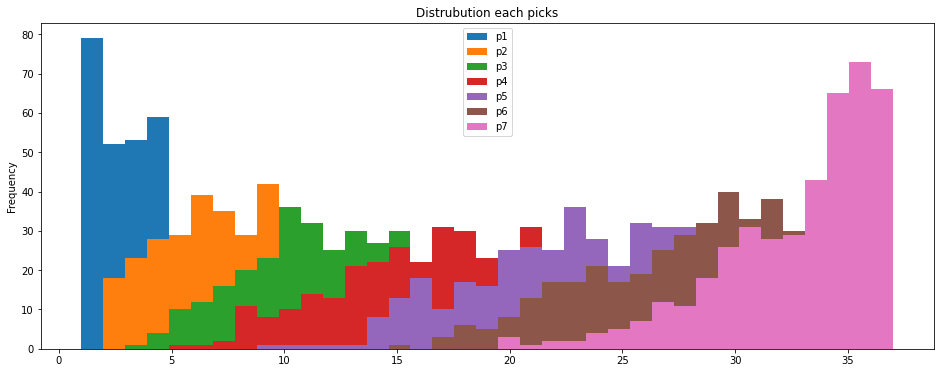

In [235]:
data.plot(kind='hist', bins=37, title='Distrubution each picks')

<AxesSubplot:title={'center':'Distrubution all'}, ylabel='Frequency'>

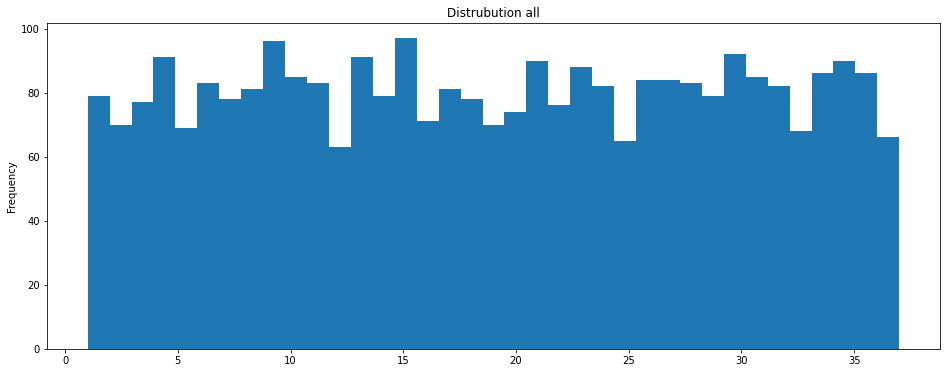

In [236]:
data.stack().reset_index(drop=True).plot(kind='hist', bins=37, title='Distrubution all')

## One-hot

In [237]:
data_list = []
for index, row in data.iterrows():
    bins = [ 0 for i in range(args.lottery_max_number) ]
    for e in row:
        bins[int(e)-1] = 1
    data_list.append( bins )
    
columns = [ str(i) for i in range(args.lottery_max_number) ]
data_one_hot = pd.DataFrame(data_list, columns=columns)
data_one_hot

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,0,0
2,0,1,0,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,1,0,0,0,0,0,1,0,1,0,...,0,1,0,1,1,0,0,0,0,0
423,0,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
424,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
425,1,1,0,0,0,1,0,1,0,0,...,0,0,1,1,0,1,0,0,0,0


## Create dataset

In [238]:
X = data_one_hot.drop(data_one_hot.tail(1).index)
y = data_one_hot.drop(data_one_hot.head(1).index)
print(X.shape)
print(y.shape)

(425, 37)
(425, 37)


In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

print( X_train.shape )
print( y_train.shape )
print( X_test.shape )
print( y_test.shape )

(340, 37)
(340, 37)
(85, 37)
(85, 37)


In [240]:
# get top k
y_test_cool = np.array(y_test).argsort()[:, -args.pick:]
# sort
y_test_cool.sort()
y_test_cool.shape

(85, 7)

## Model

### MultiOutputRegressor x GradientBoostingRegressor

In [241]:
from sklearn.multioutput import MultiOutputRegressor

from sklearn.ensemble import GradientBoostingRegressor

mor_gbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=1000, random_state=0))
mor_gbr.fit(X_train, y_train)
mor_gbr.score(X_train, y_train)

0.9958482745480797

In [242]:
pred_gbr = mor_gbr.predict(X_test)
print( mor_gbr.score(X_test, y_test) )
# get tok k
pred_gbr = pred_gbr.argsort()[:, -args.pick:]

# ont-hot
data_list = []
for row in pred_gbr:
    bins = [ 0 for i in range(args.lottery_max_number) ]
    for e in row:
        bins[int(e)-1] = 1
    data_list.append( bins )
pred_gbr = np.array(data_list)
print(pred_gbr.shape)

# Get True counts in all
pred_gbr = np.sum( (pred_gbr == y_test), axis=1)
# Get wrong counts
pred_gbr = (args.lottery_max_number - pred_gbr)/2
# Get correct counts
pred_gbr = args.pick - pred_gbr
# Calculate accuracy
pred_gbr.sum()/(args.pick * pred_gbr.count())

-0.5668479627105969
(85, 37)


0.18823529411764706

### MultiOutputRegressor x RandomForestRegressor

In [243]:
from sklearn.ensemble import RandomForestRegressor

mor_rfr = MultiOutputRegressor(RandomForestRegressor(n_estimators=1000, random_state=0))
mor_rfr.fit(X_train, y_train)
mor_rfr.score(X_train, y_train)

0.8530434432110582

In [244]:
pred_rfr = mor_rfr.predict(X_test)
print( mor_rfr.score(X_test, y_test) )
# get tok k
pred_rfr = pred_rfr.argsort()[:, -args.pick:]

# ont-hot
data_list = []
for row in pred_rfr:
    bins = [ 0 for i in range(args.lottery_max_number) ]
    for e in row:
        bins[int(e)-1] = 1
    data_list.append( bins )
pred_rfr = np.array(data_list)
print(pred_rfr.shape)

# Get True counts in all
pred_rfr = np.sum( (pred_rfr == y_test), axis=1)
# Get wrong counts
pred_rfr = (args.lottery_max_number - pred_rfr)/2
# Get correct counts
pred_rfr = args.pick - pred_rfr
# Calculate accuracy
pred_rfr.sum()/(args.pick * pred_rfr.count())

-0.12371100246856549
(85, 37)


0.1865546218487395